<a href="https://colab.research.google.com/github/LoSgu8/Network-Measurements-Lab/blob/main/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Network Measurements Lab - Homework #1
## Giacomo Sguotti - 10667547

### Assignment
You are requested to evaluate the relationship between the (average) RTT and physical distance of two endpoints

The first endpoint could be either your laptop (if you use a local python script) or a Colab VM

The second endpoint should vary and be located at increasing distances from the first endpoint

Hint: Ftp mirror servers are a good source of worldwide disseminated hosts. Some examples:
*   https://www.gnu.org/prep/ftp.html
*   https://www.debian.org/mirror/list

Use your preferred approach to estimate the average RTT

You can use (among others) the geopy.distance.distance() function of the geopy library to get the distance in km between any two pairs of (lat.long) coordinates

Gather a sufficiently diverse set of measurements, including both RTT at very short and very long distances

Plot the obtained measurements on a distance/RTT graph

A basic approximation for the RTT is a linear function of the physical distance:

						RTT = 2(L/C + d/v) + n

Estimate the average RTT per km by fitting a linear function on your set of measurement. Comment your result.

Plot the fitted line over the set of measurements

Hint: take a look at numpy.polyfit function

---

### Solution

I have analyzed all the mirrors from https://www.debian.org/mirror/list even if some of them are not always reachable.

#### Installing required Python libraries

In [1]:
!pip install --pre scapy[basic]
!pip install geopy

     |████████████████████████████████| 1.1 MB 4.2 MB/s 
  Created wheel for scapy: filename=scapy-2.4.5-py2.py3-none-any.whl size=1261555 sha256=ee3f421ab71242f5239acfb28402c6abab8e00e890babc7261b4452c3f0dbd5f
  Stored in directory: /root/.cache/pip/wheels/b9/6e/c0/0157e466a5e02d3ff28fc7587dff329b4a967a23b3f9b11385
Successfully built scapy


#### Retrieving all the Debian FTP mirrors using Pandas

In [2]:
# Retrieve the table containing all the Debian ftp mirrors from https://www.debian.org/mirror/list
import pandas as pd
url = r'https://www.debian.org/mirror/list'
tables = pd.read_html(url) # Returns list of all tables on page
mirror_list_table = tables[0].drop(columns=['Architectures'])
# Remove '/debian/' string from 'Site' column otherwise socket.gethostbyname() does not work
mirror_list_table['Site'] = mirror_list_table['Site'].str.replace('/debian/', '')
print(mirror_list_table)

           Country                Site
0          Armenia   ftp.am.debian.org
1        Australia   ftp.au.debian.org
2          Austria   ftp.at.debian.org
3          Belarus   ftp.by.debian.org
4          Belgium   ftp.be.debian.org
5           Brazil   ftp.br.debian.org
6           Canada   ftp.ca.debian.org
7            Chile   ftp.cl.debian.org
8            China   ftp.cn.debian.org
9   Czech Republic   ftp.cz.debian.org
10         Denmark   ftp.dk.debian.org
11     El Salvador   ftp.sv.debian.org
12         Estonia   ftp.ee.debian.org
13         Finland   ftp.fi.debian.org
14          France   ftp.fr.debian.org
15         Germany  ftp2.de.debian.org
16         Germany   ftp.de.debian.org
17       Hong Kong   ftp.hk.debian.org
18         Hungary   ftp.hu.debian.org
19         Iceland   ftp.is.debian.org
20           Italy   ftp.it.debian.org
21           Japan   ftp.jp.debian.org
22           Korea   ftp.kr.debian.org
23       Lithuania   ftp.lt.debian.org
24         Moldova   ftp.

#### Associate their IPs

In [3]:
# From the obtained list retrieves, for each mirror, IP addresses and add the 'IP' column to mirror_list_table
import socket

ip_addresses = []
mirror_list = mirror_list_table['Site']

for target in mirror_list:
  ip_addresses.append(socket.gethostbyname(target))

mirror_list_table['IP'] = ip_addresses

print(mirror_list_table)

           Country                Site               IP
0          Armenia   ftp.am.debian.org   93.187.162.100
1        Australia   ftp.au.debian.org    103.84.224.37
2          Austria   ftp.at.debian.org   213.129.232.18
3          Belarus   ftp.by.debian.org    82.209.230.71
4          Belgium   ftp.be.debian.org   195.234.45.114
5           Brazil   ftp.br.debian.org     200.236.31.3
6           Canada   ftp.ca.debian.org   207.210.46.249
7            Chile   ftp.cl.debian.org  138.204.231.113
8            China   ftp.cn.debian.org       45.125.0.6
9   Czech Republic   ftp.cz.debian.org   78.128.211.127
10         Denmark   ftp.dk.debian.org  130.225.254.116
11     El Salvador   ftp.sv.debian.org     186.32.99.16
12         Estonia   ftp.ee.debian.org       193.40.0.5
13         Finland   ftp.fi.debian.org    194.71.11.165
14          France   ftp.fr.debian.org     212.27.32.66
15         Germany  ftp2.de.debian.org    137.226.34.46
16         Germany   ftp.de.debian.org       141

#### Get their coordinates (lat, long)

In [4]:
# Now that we have all the IP addresses, we can retreive their location and successively their coordinates
import urllib.request
import json
from scapy.all import *


# Get (lat, lon) for each ip
coordinates = []
for ip_mirror in ip_addresses:
  ip_info = json.loads(urllib.request.urlopen('http://ip-api.com/json/' + ip_mirror).read())
  coordinates.append((ip_info['lat'], ip_info['lon']))
  
#  Add Coordinates as columns in mirror_list_table
mirror_list_table['Coordinates'] = coordinates

print(mirror_list_table)

           Country                Site               IP           Coordinates
0          Armenia   ftp.am.debian.org   93.187.162.100    (40.1817, 44.5099)
1        Australia   ftp.au.debian.org    103.84.224.37    (-35.2809, 149.13)
2          Austria   ftp.at.debian.org   213.129.232.18    (48.2098, 16.3063)
3          Belarus   ftp.by.debian.org    82.209.230.71    (53.9007, 27.5709)
4          Belgium   ftp.be.debian.org   195.234.45.114    (50.8072, 5.16609)
5           Brazil   ftp.br.debian.org     200.236.31.3  (-25.5026, -49.2908)
6           Canada   ftp.ca.debian.org   207.210.46.249   (43.2549, -79.8556)
7            Chile   ftp.cl.debian.org  138.204.231.113  (-32.8852, -71.2688)
8            China   ftp.cn.debian.org       45.125.0.6   (22.3193, 114.1693)
9   Czech Republic   ftp.cz.debian.org   78.128.211.127    (50.1018, 14.3908)
10         Denmark   ftp.dk.debian.org  130.225.254.116    (55.6802, 12.5892)
11     El Salvador   ftp.sv.debian.org     186.32.99.16   (13.65

#### Get my coordinates (lat, long)

In [5]:
# Get my coordinates based on IP address
my_ip = urllib.request.urlopen('https://api.ipify.org').read().decode('UTF-8')

my_ip_info = json.loads(urllib.request.urlopen('http://ip-api.com/json/' + my_ip).read())

my_address = my_ip_info['city'] + ',' + my_ip_info['country']

print(my_address)

my_lat = my_ip_info['lat']
my_long = my_ip_info['lon']



Taipei,Taiwan


#### Calculate the distances between my server and mirrors

In [6]:
# We can calculate the physical distances between my server coordinates and all mirrors
from geopy import distance

distances = []

my_coord = (my_lat, my_long)

coord_list = mirror_list_table['Coordinates']

for mirror_coord in coord_list:
  distances.append(distance.distance(my_coord, mirror_coord).km)

mirror_list_table['Distance (km)'] = distances

print(mirror_list_table)

           Country                Site               IP           Coordinates  \
0          Armenia   ftp.am.debian.org   93.187.162.100    (40.1817, 44.5099)   
1        Australia   ftp.au.debian.org    103.84.224.37    (-35.2809, 149.13)   
2          Austria   ftp.at.debian.org   213.129.232.18    (48.2098, 16.3063)   
3          Belarus   ftp.by.debian.org    82.209.230.71    (53.9007, 27.5709)   
4          Belgium   ftp.be.debian.org   195.234.45.114    (50.8072, 5.16609)   
5           Brazil   ftp.br.debian.org     200.236.31.3  (-25.5026, -49.2908)   
6           Canada   ftp.ca.debian.org   207.210.46.249   (43.2549, -79.8556)   
7            Chile   ftp.cl.debian.org  138.204.231.113  (-32.8852, -71.2688)   
8            China   ftp.cn.debian.org       45.125.0.6   (22.3193, 114.1693)   
9   Czech Republic   ftp.cz.debian.org   78.128.211.127    (50.1018, 14.3908)   
10         Denmark   ftp.dk.debian.org  130.225.254.116    (55.6802, 12.5892)   
11     El Salvador   ftp.sv.

#### Measure the Round Trip Time

In [7]:
# Ping all the mirrors to retrieve the Round Trip Time
mirror_list =mirror_list = mirror_list_table['Site'] # not necessary but to be more readable
nb_pings = 10; #PARAMETER: nb of pings to perform for each mirror

avg_rtt = []

for target in mirror_list:
  print('Retrieving RTT for', target, '...')
  curr_target_rtts = []
  for i in range(nb_pings):
    packet = IP(dst = target) / ICMP()
    ans, unans = sr(packet, verbose = False, timeout=5)
    if len(ans)>0:
      curr_target_rtts.append((ans[0][1].time - ans[0][0].sent_time)*1000)
  if len(curr_target_rtts) > 0:
    avg_rtt.append(sum(curr_target_rtts)/len(curr_target_rtts))
  else:
    print('\t Failed to reach, ', target, 'will not be considered')
    avg_rtt.append(float('nan'))
mirror_list_table['Average RTT (ms)'] = avg_rtt

# Remove rows of non reachable mirrors
mask = mirror_list_table['Average RTT (ms)'].isin([float('nan')])
mirror_list_table = mirror_list_table[~mask]

print(mirror_list_table)
    

Retrieving RTT for ftp.am.debian.org ...
Retrieving RTT for ftp.au.debian.org ...
Retrieving RTT for ftp.at.debian.org ...
Retrieving RTT for ftp.by.debian.org ...
Retrieving RTT for ftp.be.debian.org ...
Retrieving RTT for ftp.br.debian.org ...
Retrieving RTT for ftp.ca.debian.org ...
Retrieving RTT for ftp.cl.debian.org ...
Retrieving RTT for ftp.cn.debian.org ...
Retrieving RTT for ftp.cz.debian.org ...
Retrieving RTT for ftp.dk.debian.org ...
Retrieving RTT for ftp.sv.debian.org ...
Retrieving RTT for ftp.ee.debian.org ...
Retrieving RTT for ftp.fi.debian.org ...
Retrieving RTT for ftp.fr.debian.org ...
Retrieving RTT for ftp2.de.debian.org ...
Retrieving RTT for ftp.de.debian.org ...
Retrieving RTT for ftp.hk.debian.org ...
Retrieving RTT for ftp.hu.debian.org ...
	 Failed to reach,  ftp.hu.debian.org will not be considered
Retrieving RTT for ftp.is.debian.org ...
Retrieving RTT for ftp.it.debian.org ...
Retrieving RTT for ftp.jp.debian.org ...
Retrieving RTT for ftp.kr.debian.org

#### Plot the measured RTT in function of the distance

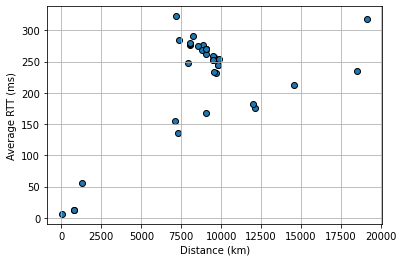

In [8]:
# plotting the Measured Round Trip Times
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure()
plt.scatter(mirror_list_table['Distance (km)'], mirror_list_table['Average RTT (ms)'], facecolor='C0', edgecolor='k')
plt.xlabel('Distance (km)')
plt.ylabel('Average RTT (ms)')
plt.grid(visible = True)

#### Compare the RTT measured fitted line with the RTT estimation

Text(0, 0.5, 'RTT (ms)')

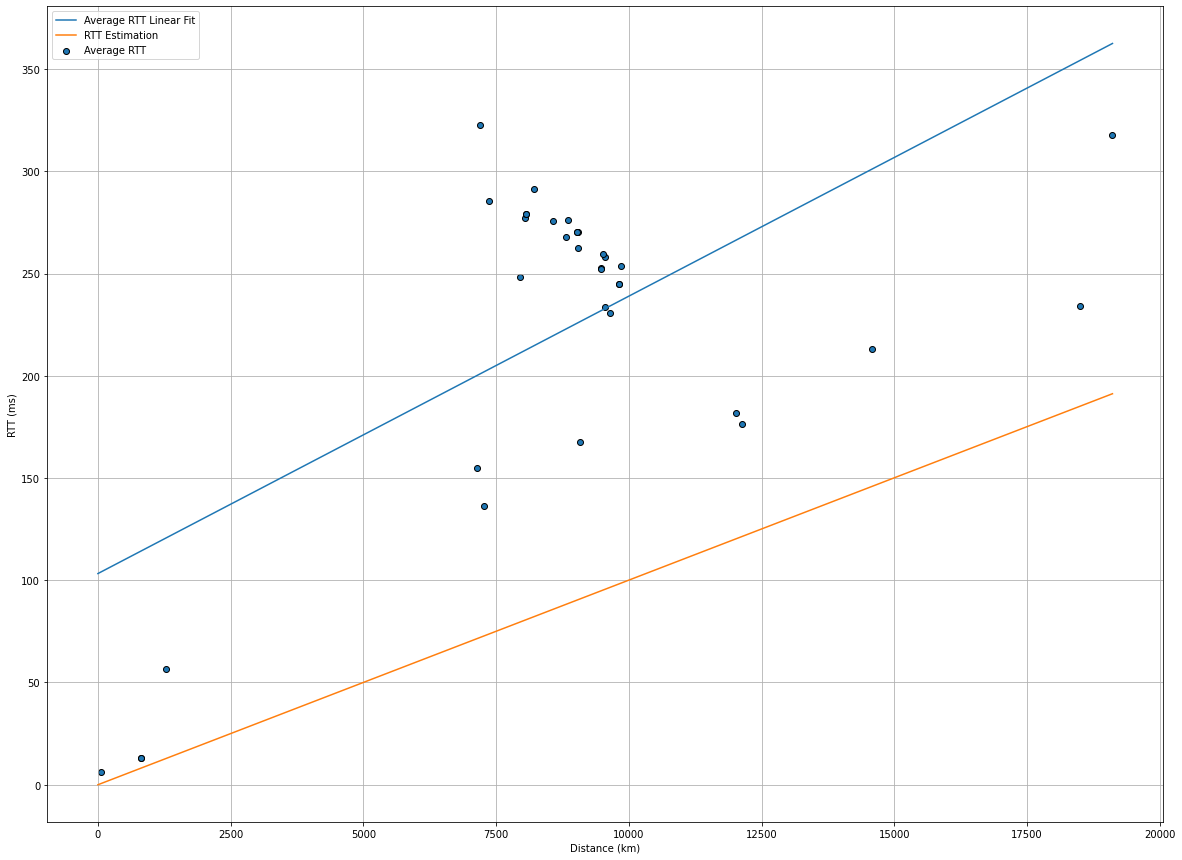

In [9]:
# 4th point
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,15))

# Fitted Line over the set of measurements
z = np.polyfit(mirror_list_table['Distance (km)'], mirror_list_table['Average RTT (ms)'], 1)
p = np.poly1d(z)
xp = np.linspace(0, round(max(mirror_list_table['Distance (km)'])))

# Set of measurements
plt.scatter(mirror_list_table['Distance (km)'], mirror_list_table['Average RTT (ms)'], facecolor='C0', edgecolor='k', label='Average RTT')
plt.plot(xp, p(xp), label="Average RTT Linear Fit")

# Estimated RTT
# Given formula RTT = 2(L/C + d/v) + n 
# Let's plot the estimation with the following assumptions L/C negligible, v = 2/3*c (where c = 299.792458 [km/ms] is the speed of light) and n = 0
propagation_speed = 299.792458*2/3
estimated_RTT = 2*xp/propagation_speed
plt.plot(xp, estimated_RTT, label="RTT Estimation")

plt.legend()
plt.grid(visible=True)
plt.xlabel('Distance (km)')
plt.ylabel('RTT (ms)')


In [16]:
print('Real RTT = {}x + {}'.format(z[0], z[1]))

Real RTT = 0.013566336275229525x + 103.27735508955958


#### Comment on the final plot
The Estimated RTT is smaller than the measured one.
This is due to the fact that estimation does not consider the presence of a network but see the connection as a single end to end long fiber optic cable. The queuing and processing time of each hop through the path and the path topology which justifies the huge difference between the two Round Trip Times.

Despite this, the trend of the measured RTT is linear as the theoretical one.

Below, I developed a traceroute visualizer that shows that the distance as the crow flies does not match with the real path of the packet.

In [25]:
import socket
from scapy.all import *
import ipaddress
#import statistics

hostname = "ftp.au.debian.org" # the plot is not always correct
target_ip = socket.gethostbyname(hostname)
max_ttl = 30

ip_hops = []

# append my IP
ip_hops.append(my_ip)

#then append all the hops until the destination is reached
for i in range(max_ttl):
  packet = IP(dst = target_ip, ttl=i+1) / ICMP(seq = i)
  ans, unans = sr(packet, verbose = False, timeout = 5)
  if len(ans)>0:
    query = ans[0][0]
    answer = ans[0][1]
    if ipaddress.ip_address(answer.src).is_private != True:
      ip_hops.append(answer.src)
    if answer.src == target_ip:
      break;

print(ip_hops)

['35.201.141.56', '138.44.10.40', '113.197.15.11', '138.44.161.3', '150.203.201.5', '150.203.201.13', '103.84.224.37']


In [26]:
lats = []
longs = []
coordinates = []
for ip in ip_hops:
  ip_info = json.loads(urllib.request.urlopen('http://ip-api.com/json/' + ip).read())
  lats.append(ip_info['lat'])
  longs.append(ip_info['lon'])
  coordinates.append((ip_info['lat'], ip_info['lon']))


In [23]:
!pip install geopandas

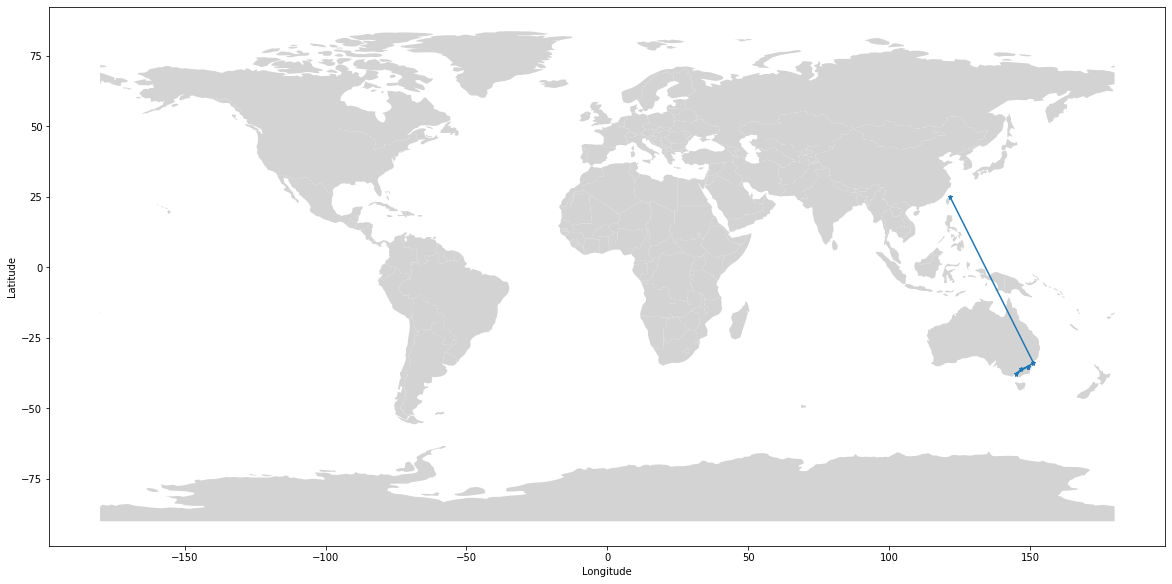

In [27]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(coordinates)
df.columns = ['Latitude', 'Longitude']
fig, ax = plt.subplots(figsize=(20,15))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world.plot(color="lightgrey", ax=ax)

df.plot(x="Longitude", y="Latitude", ylabel="Latitude", ax=ax, marker="*", markersize=5, legend=False);